In [25]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import os
import json
import torch
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from nerfstudio.utils.eval_utils import eval_setup
from plane_nerf.inerf_trainer import load_data_into_trainer
from plane_nerf.inerf_utils import inerf_v2
from plane_nerf.inerf_utils import load_eval_image_into_pipeline


In [27]:
os.chdir('/workspace/plane-nerf')
MODEL_PATH = "/workspace/plane-nerf/outputs/jackal_floor_training_data_1/plane-nerf-fast/2024-03-18_221148"
DATA_PATH = "/stored_data/jackal_one_frame"
GROUND_TRUTH_PATH = os.path.join(DATA_PATH, "ground_truth.json")
config_path = os.path.join(MODEL_PATH, "config.yml")
config, pipeline, _, _ = eval_setup(
                        Path(config_path),
                        test_mode="inference",
                    )
transform_file_path = "transforms.json"
with open(os.path.join(DATA_PATH, transform_file_path)) as f:
    transform = json.load(f)

pipeline = load_eval_image_into_pipeline(pipeline,DATA_PATH,transform)

config.pipeline.datamanager.pixel_sampler.num_rays_per_batch = 4096 

trainer = load_data_into_trainer(
    config,
    pipeline,
    plane_optimizer = True
)
trainer.pipeline.datamanager.KERNEL_SIZE = 5
trainer.pipeline.datamanager.THRESHOLD = 40
trainer.pipeline.datamanager.METHOD = "sift"

tiny-cuda-nn warning: FullyFusedMLP is not supported for the selected architecture 52. Falling back to CutlassMLP. For maximum performance, raise the target GPU architecture to 75+.
tiny-cuda-nn warning: FullyFusedMLP is not supported for the selected architecture 52. Falling back to CutlassMLP. For maximum performance, raise the target GPU architecture to 75+.
tiny-cuda-nn warning: FullyFusedMLP is not supported for the selected architecture 52. Falling back to CutlassMLP. For maximum performance, raise the target GPU architecture to 75+.
tiny-cuda-nn warning: FullyFusedMLP is not supported for the selected architecture 52. Falling back to CutlassMLP. For maximum performance, raise the target GPU architecture to 75+.
tiny-cuda-nn warning: FullyFusedMLP is not supported for the selected architecture 52. Falling back to CutlassMLP. For maximum performance, raise the target GPU architecture to 75+.
tiny-cuda-nn warning: FullyFusedMLP is not supported for the selected architecture 52. Fal

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from 
outputs/jackal_floor_training_data_1/plane-nerf-fast/2024-03-18_221148/nerfstudio_models/step-000009999.ckpt

Setting up training dataset...

Caching all 1 images.

Loading PlaneNerfCameraOptimizer


[13:00:17] Saving checkpoints to:                                                                         ]8;id=990096;file:///home/user/nerfstudio/nerfstudio/engine/trainer.py\trainer.py]8;;\:]8;id=278762;file:///home/user/nerfstudio/nerfstudio/engine/trainer.py#136\136]8;;\
           outputs/jackal_floor_training_data_1/plane-nerf-fast/2024-03-18_221148/nerfstudio_models                     

Loading latest Nerfstudio checkpoint from load_dir...


Done loading Nerfstudio checkpoint from 
outputs/jackal_floor_training_data_1/plane-nerf-fast/2024-03-18_221148/nerfstudio_models/step-000009999.ckpt

In [28]:
print(trainer.pipeline.model.camera_optimizer.pose_adjustment)

Parameter containing:
tensor([[0., 0., 0.]], device='cuda:0', requires_grad=True)


In [29]:
with open(GROUND_TRUTH_PATH) as f:
    ground_truth_transform = json.load(f)
ground_truth_poses = []
tf = ground_truth_transform["frames"][0]["transform_matrix"]
tf = np.asarray(tf)
tf = tf[:3, :4 ]
ground_truth_poses.append(tf)
ground_truth_poses = torch.tensor(ground_truth_poses).to(trainer.pipeline.device)

In [30]:
import time
start = time.time()
ans = inerf_v2(trainer,GROUND_TRUTH_POSE=ground_truth_poses)
end = time.time()
print("Time taken for inference: ", end-start)

Number of keypoints:  126
Number of rays:  5418
Reduce the number of rays
Final number of rays:  4096
tensor([[[ 8.7173e-01,  3.3281e-01, -3.5960e-01, -5.1848e-01],
         [-4.8947e-01,  6.2490e-01, -6.0821e-01, -7.9319e-01],
         [ 2.2295e-02,  7.0621e-01,  7.0765e-01,  2.1123e-04]]])
{'loss': tensor([0.0246], device='cuda:0', grad_fn=<AddBackward0>)}
tensor([[[ 1.2901e-01,  6.9948e-01, -7.0292e-01, -9.1415e-01],
         [-9.9139e-01,  1.0688e-01, -7.5600e-02, -7.1397e-02],
         [ 2.2244e-02,  7.0662e-01,  7.0724e-01, -3.1245e-04]]],
       device='cuda:0', grad_fn=<SliceBackward0>)
Loading latest Nerfstudio checkpoint from load_dir...


Done loading Nerfstudio checkpoint from 
outputs/jackal_floor_training_data_1/plane-nerf-fast/2024-03-18_221148/nerfstudio_models/step-000009999.ckpt

Number of keypoints:  126
Number of rays:  5418
Reduce the number of rays
Final number of rays:  4096
tensor([[[ 1.2901e-01,  6.9948e-01, -7.0292e-01, -9.1415e-01],
         [-9.9139e-01,  1.0688e-01, -7.5600e-02, -7.1397e-02],
         [ 2.2244e-02,  7.0662e-01,  7.0724e-01, -3.1245e-04]]],
       device='cuda:0', grad_fn=<SliceBackward0>)
Parameter containing:
tensor([[0., 0., 0.]], device='cuda:0', requires_grad=True)
Time taken for inference:  34.46771216392517


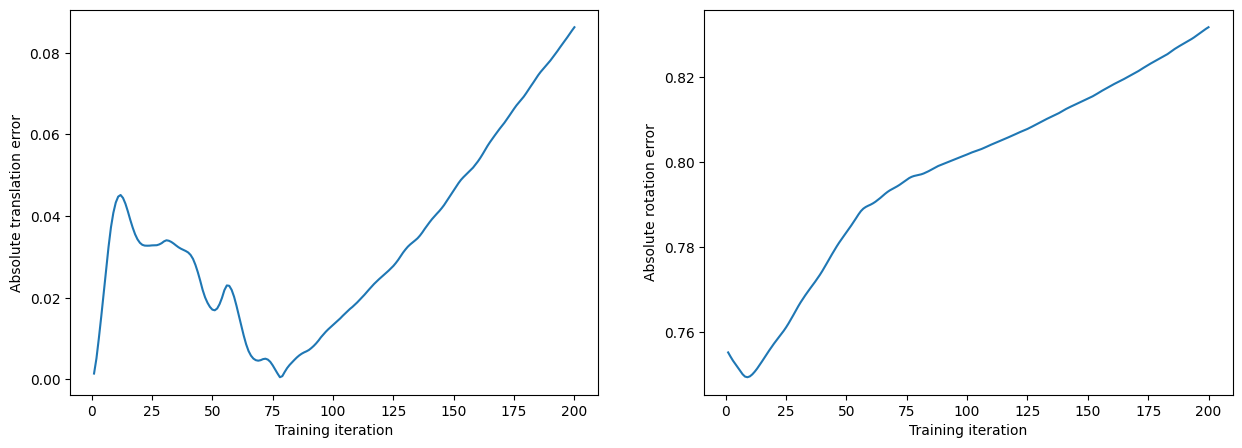

In [31]:
#Plot store_t_diff and store_r_diff with  respect to training iteration in 2 subplots

plotting_data = np.asarray(ans["store"].to("cpu"))
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(plotting_data[:, 0], plotting_data[:, 1])
plt.xlabel("Training iteration")
plt.ylabel("Absolute translation error")
plt.subplot(1, 2, 2)
plt.plot(plotting_data[:, 0], plotting_data[:, 2])
plt.xlabel("Training iteration")
plt.ylabel("Absolute rotation error")
plt.show()

In [32]:
print(ans["store"])

tensor([[1.0000e+00, 1.4348e-03, 7.5523e-01],
        [2.0000e+00, 5.1647e-03, 7.5423e-01],
        [3.0000e+00, 1.0132e-02, 7.5329e-01],
        [4.0000e+00, 1.5487e-02, 7.5248e-01],
        [5.0000e+00, 2.1128e-02, 7.5166e-01],
        [6.0000e+00, 2.6771e-02, 7.5086e-01],
        [7.0000e+00, 3.2446e-02, 7.5008e-01],
        [8.0000e+00, 3.7243e-02, 7.4953e-01],
        [9.0000e+00, 4.0817e-02, 7.4938e-01],
        [1.0000e+01, 4.3329e-02, 7.4958e-01],
        [1.1000e+01, 4.4774e-02, 7.5005e-01],
        [1.2000e+01, 4.5175e-02, 7.5068e-01],
        [1.3000e+01, 4.4449e-02, 7.5141e-01],
        [1.4000e+01, 4.3043e-02, 7.5222e-01],
        [1.5000e+01, 4.1175e-02, 7.5308e-01],
        [1.6000e+01, 3.9106e-02, 7.5396e-01],
        [1.7000e+01, 3.7212e-02, 7.5483e-01],
        [1.8000e+01, 3.5559e-02, 7.5568e-01],
        [1.9000e+01, 3.4312e-02, 7.5651e-01],
        [2.0000e+01, 3.3465e-02, 7.5731e-01],
        [2.1000e+01, 3.2970e-02, 7.5807e-01],
        [2.2000e+01, 3.2780e-02, 7